# Age prediction on structural data from HBN

## Load and Prepare the data 

Start out impoting the classes and functions we might need

In [271]:
import numpy as np
#from xgboost import XGBClassifier
#from xgboost import XGBRegressor

#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

import csv
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm


Loading the csv's as panda dataframe

In [125]:
# Loading Pheno 
all_pheno = pd.read_csv('Pheno_complete.csv')
#print(all_pheno.shape) = (366, 3)
#sex = all_pheno.Sex
#age = all_pheno.Age.values # converting to numpy array
#print(age)

# to get only the values: age.values

# Loading cortical thickness
cortical_thickness = pd.read_csv('Cortical_thickness_allRegion.csv')
#print(cortical_thickness.shape) = (1458, 63)
cortical_thickness_HCP = cortical_thickness[cortical_thickness['sub-type'].str.endswith('HCP')]
cortical_thickness_HCP_run01 = cortical_thickness[cortical_thickness['sub-type'].str.endswith('HCP_run-01')]
cortical_thickness_HCP_all = pd.concat([cortical_thickness_HCP,cortical_thickness_HCP_run01])
#print(cortical_thickness_HCP_all.shape) = (372, 63)

cortical_thickness_VNavNorm = cortical_thickness[cortical_thickness['sub-type'].str.endswith('VNavNorm')]
cortical_thickness_VNavNorm_run01 = cortical_thickness[cortical_thickness['sub-type'].str.endswith('VNavNorm_run-01')]
cortical_thickness_VNavNorm_all = pd.concat([cortical_thickness_VNavNorm,cortical_thickness_VNavNorm_run01])
#print(cortical_thickness_VNavNorm_all.shape) = (428, 63)

# area
area = pd.read_csv('area_allRegion.csv')
#print(area.shape) = (1458, 63)
area_HCP = area[area['subid'].str.endswith('HCP')]
area_HCP_run01 = area[area['subid'].str.endswith('HCP_run-01')]
area_HCP_all = pd.concat([area_HCP,area_HCP_run01])
#print(area_HCP_all.shape) = (372, 63)

area_VNavNorm = area[area['subid'].str.endswith('VNavNorm')]
area_VNavNorm_run01 = area[area['subid'].str.endswith('VNavNorm_run-01')]
area_VNavNorm_all = pd.concat([area_VNavNorm,area_VNavNorm_run01])
#print(area_VNavNorm_all.shape) = (428, 63)


# loading volume
volume = pd.read_csv('Volume_allRegion.csv')
#print(volume.subid)
volume_HCP = volume[volume['subid'].str.endswith('HCP')]
volume_HCP_run01 = volume[volume['subid'].str.endswith('HCP_run-01')]
volume_HCP_all = pd.concat([volume_HCP,volume_HCP_run01])
#print(area_HCP_all.shape)  = (372, 63)

volume_VNavNorm = volume[volume['subid'].str.endswith('VNavNorm')]
volume_VNavNorm_run01 = volume[volume['subid'].str.endswith('VNavNorm_run-01')]
volume_VNavNorm_all = pd.concat([volume_VNavNorm,volume_VNavNorm_run01])
#print(volume_VNavNorm_all.shape) = (430, 169)



Now we need to get a list of subjects that are in all datasets 
As it looks like, the dataset with the phenotypical data is the most restrictive, with 366 rows. 


In [126]:
#print(all_pheno)

#initialize a list
#blah = {columns=['subjid']}
list_subj = pd.DataFrame(columns=['subjid'])
#print(list_subj)


#print(cortical_thickness_HCP_all['sub-type'].str[:7])

cortical_thick_subjid_HCP = cortical_thickness_HCP_all['sub-type'].str[:7]
cortical_thick_subjid_vNav = cortical_thickness_VNavNorm_all['sub-type'].str[:7]

#print(cortical_thick)    
#print(cortical_thick)
#a = cortical_thick.str.contains('5069025')
#print(a)

# Going though a loop of the subject list that has phenotypical data and seeing which subjects match in the list that also have cortical thickness. 
for subjid in all_pheno['subid'].str[-7:]:
    #print(subjid)
    #print(type(cortical_thickness_HCP_all['sub-type'].str[:7]))
       
    if (cortical_thick_subjid_HCP.str.contains(subjid).any() and  cortical_thick_subjid_vNav.str.contains(subjid).any()):
        #print([subjid])
        list_subj=list_subj.append({'subjid': subjid},ignore_index=True)
        #print(list_subj)
    else:
        a=1
        #print("Nope")
    
#print("This is the list of subjects that have age and cortical thickness: ")
print(list_subj.shape)


(327, 1)


Now need to create a list of subects based on sex (males and females)

In [127]:
list_subj_male = pd.DataFrame(columns=['subid','Age',"Sex"])
list_subj_female = pd.DataFrame(columns=['subid','Age',"Sex"])
#print(list_subj['subjid'].str[:])


#print(all_pheno.loc[:])

#blah = all_pheno[all_pheno['subid'] == ("sub-" + "5098010")]

for subjid in list_subj['subjid'].str[:]:
    blah = all_pheno[all_pheno['subid'] == ("sub-" + subjid)]
    
    
    #print(type(blah['Sex'].str[:].to_string()))
    #print((blah['Sex'].str.contains("M")).any())
    
    if (blah['Sex'].str.contains("M")).any():
        #print("Male")
        list_subj_male = pd.concat([list_subj_male, blah],ignore_index=True)  
    else:
        #print("Female")
        list_subj_female = pd.concat([list_subj_female, blah],ignore_index=True) 

#print(list_subj_male.shape) 
#print(list_subj_female.shape) 



 Now matching the list of males and females with the cortical thickness values

In [151]:
#print(cortical_thickness_HCP_all)
#print(cortical_thickness_VNavNorm_all)

# initiating the dataframe
cortical_thickness_HCP_male = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)
cortical_thickness_HCP_female = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)
cortical_thickness_vNav_male = pd.DataFrame(data=None, columns=cortical_thickness_VNavNorm_all.columns)
cortical_thickness_vNav_female = pd.DataFrame(data=None, columns=cortical_thickness_VNavNorm_all.columns)


# looping though males first
for subjid in list_subj_male['subid'].str[4:]:
    #print(subjid)
    # Getting the MPRAGE data
    blah = cortical_thickness_HCP_all[cortical_thickness_HCP_all["sub-type"].str.contains(subjid)]
    cortical_thickness_HCP_male = pd.concat([cortical_thickness_HCP_male, blah],ignore_index=True) 
    
    # Now the vNav
    blah = cortical_thickness_VNavNorm_all[cortical_thickness_VNavNorm_all["sub-type"].str.contains(subjid)]
    cortical_thickness_vNav_male = pd.concat([cortical_thickness_vNav_male, blah],ignore_index=True) 
    
    
    
# now looping through the females
for subjid in list_subj_female['subid'].str[4:]:
    #print(subjid)
    # Getting the MPRAGE data
    blah = cortical_thickness_HCP_all[cortical_thickness_HCP_all["sub-type"].str.contains(subjid)]
    cortical_thickness_HCP_female = pd.concat([cortical_thickness_HCP_female, blah],ignore_index=True) 
    
    # Now the vNav
    blah = cortical_thickness_VNavNorm_all[cortical_thickness_VNavNorm_all["sub-type"].str.contains(subjid)]
    cortical_thickness_vNav_female = pd.concat([cortical_thickness_vNav_female, blah],ignore_index=True) 

    
# now save everthing in csv files
list_subj_male.to_csv(r'list_pheno_males.csv', index = None, header=True)
list_subj_female.to_csv(r'list_pheno_females.csv', index = None, header=True)


cortical_thickness_HCP_male.to_csv(r'list_cortical_thickness_HCP_male.csv', index = None, header=True)
cortical_thickness_vNav_male.to_csv(r'list_cortical_thickness_vNav_male.csv', index = None, header=True)
cortical_thickness_HCP_female.to_csv(r'list_cortical_thickness_HCP_female.csv', index = None, header=True)
cortical_thickness_vNav_female.to_csv(r'list_cortical_thickness_vNav_female.csv', index = None, header=True)




Total number os subjects:   
list_subj_male = 209   
list_subj_female = 118 


## Now going to do some statistics (ANCOVA)
## !!! REMEMBER - this needs to be changed to a repeted samples ANCOVA

Now just organizing the data to easily be used

In [249]:
# for males, combine the HCP vNav and pheno dataframes

for name in column_names[0:62]:
    #print(name)
    cortical_thickness_HCP_male.rename(columns={name: name + "_HCP"}, inplace = True)
    cortical_thickness_vNav_male.rename(columns={name: name + "_vNav"}, inplace = True)
    

cortical_thickness_male = pd.merge(cortical_thickness_HCP_male,cortical_thickness_vNav_male, how='outer',  left_index=True, right_index=True)
all_male = pd.merge(list_subj_male,cortical_thickness_male, how='outer',  left_index=True, right_index=True)

#print(all_male.shape)

#for females, combine the HCP vNav and pheno dataframes
for name in column_names[0:62]:
    #print(name)
    cortical_thickness_HCP_female.rename(columns={name: name + "_HCP"}, inplace = True)
    cortical_thickness_vNav_female.rename(columns={name: name + "_vNav"}, inplace = True)
    

cortical_thickness_female = pd.merge(cortical_thickness_HCP_female,cortical_thickness_vNav_female, how='outer',  left_index=True, right_index=True)
all_female = pd.merge(list_subj_female,cortical_thickness_female, how='outer',  left_index=True, right_index=True)

#print(all_female.shape)
#all_male.describe()

#all_female.describe()

#all_male[['ctx-lh-caudalanteriorcingulate_HCP', 'ctx-lh-caudalanteriorcingulate_vNav']].plot(kind='box')
# Running paired t-tests
for name in column_names[0:62]:
    #stats.ttest_rel(all_male['ctx-lh-caudalanteriorcingulate_HCP'], all_male['ctx-lh-caudalanteriorcingulate_vNav'])
    t_statistic, p_value = stats.ttest_rel(all_male[name + '_HCP'], all_male[name + '_vNav'])
    #print(name + ", " + str(t_statistic) + ", " + str(p_value) )

    


for name in column_names[0:62]:
    #stats.ttest_rel(all_male['ctx-lh-caudalanteriorcingulate_HCP'], all_male['ctx-lh-caudalanteriorcingulate_vNav'])
    t_statistic, p_value = stats.ttest_rel(all_female[name + '_HCP'], all_female[name + '_vNav'])
    print(name + ", " + str(t_statistic) + ", " + str(p_value) )
    
    
    
    

ctx-lh-caudalanteriorcingulate, 5.910298854869466, 3.44437726340626e-08
ctx-lh-caudalmiddlefrontal, 0.34631892154103733, 0.7297250708900643
ctx-lh-cuneus, -1.957761535239356, 0.05263880474500409
ctx-lh-entorhinal, -3.300941767227316, 0.0012778914837533423
ctx-lh-fusiform, 3.382106775554972, 0.000978782299925813
ctx-lh-inferiorparietal, 2.9287431195687827, 0.004091857633478332
ctx-lh-inferiortemporal, 1.1538291496466737, 0.2509217428633127
ctx-lh-insula, 1.9602108797196305, 0.05234833626157832
ctx-lh-isthmuscingulate, 7.152410250953057, 7.97794568800063e-11
ctx-lh-lateraloccipital, 0.796111459118271, 0.4275795979848409
ctx-lh-lateralorbitofrontal, -1.5985456208312963, 0.11261876322929307
ctx-lh-lingual, -3.763539562638734, 0.00026345260345859544
ctx-lh-medialorbitofrontal, 2.2326861393565762, 0.027472425029833214
ctx-lh-middletemporal, 1.1207184866061208, 0.26470282820072544
ctx-lh-paracentral, 2.988206346672896, 0.0034201631032162332
ctx-lh-parahippocampal, 3.288269976587544, 0.0013316

Now lets see if there is an age effect on the difference between measurements

Age
20.466575


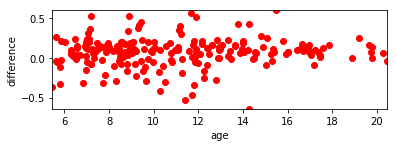

In [308]:
# need to build another database, but now with the differences between MPRAGE and vNav

# copy the columns of a dataframe 
cortical_thickness_diff_male = pd.DataFrame(data=None, columns=cortical_thickness_HCP_all.columns)

#cortical_thickness_HCP_all['ctx-lh-caudalanteriorcingulate'] 

#a = all_male[column_names[0] + "_HCP"] - all_male[column_names[0] + "_vNav"]
#print(a)
#print(list(all_male))

#print(column_names[61])


for name in column_names[0:62]:
    cortical_thickness_diff_male[name] = all_male[name + "_HCP"] - all_male[name + "_vNav"]

#print(cortical_thickness_diff_male[column_names[0]])
r = np.array(cortical_thickness_diff_male[column_names[0]])

age = np.array(all_male[column_names[64]])

print(column_names[64]) # 64 is age
print(age.max())

plt.figure()
plt.subplot(211)
plt.plot(age,r,'ro')
plt.axis([age.min(), age.max(), r.min(), r.max()])
plt.xlabel('age')
plt.ylabel('difference')
plt.show()
#    name + "_vNav"
#Example on how to do regression ! 
#http://www.alexsalo.xyz/ancova-comparing-regression-slopes/